In [1]:
import pandas as pd

In [11]:
# Load Dataset
test_df = pd.read_csv('..\indexing\data\splitted_data\\v2\\test.csv')

In [12]:
test_df.head()

,instansi,status,reference
0,kementerian agraria dan tata ruang/badan perta...,yes,kementerian agraria
1,kementerian agraria dan tata ruang/badan perta...,yes,kementerian tata ruang
2,kementerian agraria dan tata ruang/badan perta...,yes,kementerian badan pertanahan nasional
3,kementerian agraria dan tata ruang/badan perta...,yes,badan pertanahan nasional
4,kementerian agraria dan tata ruang/badan perta...,yes,atr


In [17]:
list_model = ['indobert-base-p1', 'indobert-base-p2']
INDEX = 0

In [18]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/{}'.format(list_model[INDEX]))
labels = {'no':0,
          'yes':1,
          }


In [26]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        
        self.labels = [labels[label] for label in df['status']]
        self.texts = [tokenizer(df['instansi'][i], df['reference'][i],
                               padding='max_length', max_length = 512, truncation=True, 
                               return_tensors="pt") for i in range(df.index[0],df.index[-1] + 1)]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [20]:
from torch import nn
from transformers import BertModel

In [21]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('indobenchmark/{}'.format(list_model[INDEX]))
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [22]:
model = torch.load('Models/{}'.format(list_model[INDEX]))

In [23]:
import torch.nn.functional as F

In [24]:
test_df = test_df.iloc[0:100,:]

In [39]:
#Predict
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    probs = []
    preds = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              prob = F.softmax(output, dim=1)
              pred = output.argmax(dim=1)
              probs.append(prob)
              preds.append(pred)

              #pred_class
              temp_pred = []
              for i in range(0,len(preds)):
                a = preds[i].cpu().numpy().tolist()
                temp_pred.append(a)
              list_pred = [x for y in temp_pred for x in y]
              
              #prob values
              temp_prob = []
              for i in range(0,len(probs)):
                a = probs[i].cpu().numpy().tolist()
                temp_prob.append(a)
              list_prob = [max(x) for y in temp_prob for x in y]


              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    new_test_data = test_data.copy()
    new_test_data['pred'] = list_pred
    new_test_data['prob'] = list_prob

    new_test_data = new_test_data[['reference', 'instansi', 'status', 'pred', 'prob']]

    return new_test_data
      
pred_result = evaluate(model, test_df)
pred_result.to_csv('result/hasil_prediksi_{}.csv'.format(list_model[INDEX]))

Test Accuracy:  0.810


In [40]:
pred_result

,reference,instansi,status,pred,prob
0,kementerian agraria,kementerian agraria dan tata ruang/badan perta...,yes,1,0.713816
1,kementerian tata ruang,kementerian agraria dan tata ruang/badan perta...,yes,1,0.976294
2,kementerian badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.996332
3,badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.995848
4,atr,kementerian agraria dan tata ruang/badan perta...,yes,1,0.806893
...,...,...,...,...,...
95,bank indonesia (bi),bank indonesia (bi),yes,1,0.995804
96,bi,bank indonesia (bi),yes,1,0.996293
97,bank internasional indonesia,bank indonesia (bi),no,1,0.882971
98,pemerintahan gianyar,pemerintah kabupaten gianyar,yes,1,0.998247


In [30]:
pred_result['reference'].unique().tolist()

['kementerian agraria',
 'kementerian tata ruang',
 'kementerian badan pertanahan nasional',
 'badan pertanahan nasional',
 'atr',
 'bpn',
 'atr/bpn',
 'agraria',
 'agraria dan tata ruang',
 'tata ruang',
 'kementerian energi',
 'kementerian sumber daya mineral',
 'esdm',
 'energi',
 'sumber daya mineral',
 'kementerian energi dan sumber daya mineral',
 'kementerian hukum',
 'kementerian hukum dan ham',
 'kementerian ham',
 'kementerian hak asasi manusia',
 'hukum dan ham',
 'hukum',
 'ham',
 'kemenkumham',
 'kemenkes',
 'kesehatan',
 'kementerian kemenkes',
 'kementerian komunikasi',
 'kementerian informatika',
 'kominfo',
 'informatika',
 'komunikasi',
 'komunikasi dan informatika',
 'kemlu',
 'kemlu ri',
 'luar negeri',
 'kementrian dalam negeri',
 'kementrian bumn',
 'kemen bumn',
 'bumn',
 'badan usaha milik negara',
 'kemenparekraf',
 'kemenparekraf ri',
 'dinas pariwisata dan kebudayaan kota bogor',
 'dinas kebudayaan dan pariwisata kota bandung',
 'kemen pppa',
 'kementrian pp 

In [41]:
#Ambil hasil prediksi dengan nilai confidence tertinggi
lst_sinonim = pred_result['reference'].unique().tolist()

idx_to_take = []
for sinonim in lst_sinonim:
    df_sn = pred_result[pred_result['reference']==sinonim]
    df_sn = df_sn.drop_duplicates()
    if 1 in df_sn['pred'].values:
        df_sn_new = df_sn[df_sn['pred']==1]
        idx = df_sn_new[df_sn_new['prob']==df_sn_new['prob'].max()].index.tolist()
        for id in idx :
            idx_to_take.append(id)
    elif 1 not in df_sn['pred'].values:
        df_sn_new = df_sn[df_sn['pred']==0]
        idx = df_sn_new[df_sn_new['prob']==df_sn_new['prob'].max()].index.tolist()
        if len(idx) > 1:
            print(len(idx))
        for id in idx :
            idx_to_take.append(id)

new_result_df = pred_result.loc[idx_to_take,:]
new_result_df

,reference,instansi,status,pred,prob
0,kementerian agraria,kementerian agraria dan tata ruang/badan perta...,yes,1,0.713816
1,kementerian tata ruang,kementerian agraria dan tata ruang/badan perta...,yes,1,0.976294
2,kementerian badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.996332
3,badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.995848
4,atr,kementerian agraria dan tata ruang/badan perta...,yes,1,0.806893
...,...,...,...,...,...
95,bank indonesia (bi),bank indonesia (bi),yes,1,0.995804
96,bi,bank indonesia (bi),yes,1,0.996293
97,bank internasional indonesia,bank indonesia (bi),no,1,0.882971
98,pemerintahan gianyar,pemerintah kabupaten gianyar,yes,1,0.998247


In [42]:
#Confusion Matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [45]:
pred_result['status'] = pred_result['status'].map({"yes" : 1, "no" : 0})

In [46]:
label_true = pred_result['status'].values
prediction = pred_result['pred'].values

cf_matrix = confusion_matrix(label_true, prediction)

<AxesSubplot:>

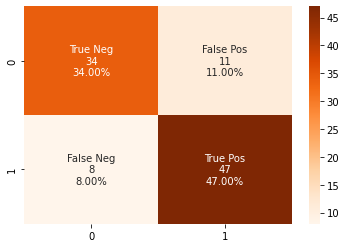

In [47]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')